In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import torch
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
from scib_metrics.benchmark import Benchmarker

In [6]:
adata = sc.read_h5ad("data/Immune_ALL_human.h5ad")
# adata with precomputed embedding from scVI
adata_scvi = sc.read_h5ad("reports/scvi_immune.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [19]:
adata_scvi

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'scVI'
    layers: 'counts'

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# sc.pp.scale(adata, max_value=10)

## Unintegrated

In [8]:
sc.tl.pca(adata)
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

In [14]:
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.umap(adata)

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


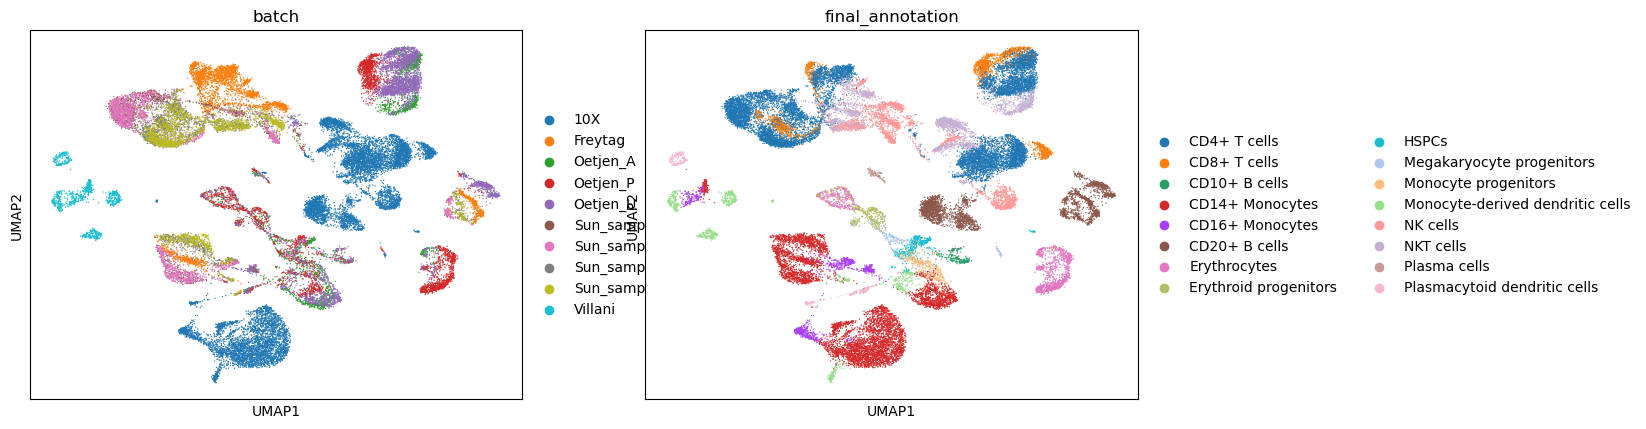

In [15]:
sc.pl.umap(adata, color=["batch", "final_annotation"])

## VAE with loss = MSE + 0.1 sum(1/LISI(batch))

In [11]:
from src.types import TrainParams
from src.vae.model import VAE
from src.model import ModelParams

model_params = ModelParams(beta=0.01, n_layers=2, z_dim=100, n_hidden=300, use_cuda=True)
torch.set_num_threads(16)

model = VAE(adata, model_params)
train_params = TrainParams(train_size=0.8, n_epochs=100, learning_rate=1e-4, batch_size=128, params_file="benchmark_human_immune_metrics")

In [12]:
model_dict = torch.load('mvae_params/benchmark_human_immune_0.1_20230403-233946.pt', map_location='cuda')
model.load_state_dict(model_dict)

<All keys matched successfully>

In [13]:
from src.vae.train import to_latent
emb = to_latent(model, adata, ["batch"], train_params)
adata.obsm["X_vae"] = np.vstack([x.numpy() for x in emb])

100%|██████████████████████████████████████████████████████████████████████| 262/262 [00:15<00:00, 17.14it/s]


In [17]:
sc.pp.neighbors(adata, use_rep="X_vae", n_neighbors=30)
sc.tl.umap(adata)

## VAE with loss = MSE + 0.1 sum (1/LISI(batch)) with normalization of latent before LISI calculation (=> knn calculated with cos distance, instead of euclidean)

In [22]:
model = VAE(adata, model_params)
model_dict = torch.load('mvae_params/benchmark_human_immune_normal_0.1_batch_20230406-223450.pt', map_location='cuda')
model.load_state_dict(model_dict)

<All keys matched successfully>

In [23]:
emb = to_latent(model, adata, ["batch"], train_params)
adata.obsm["X_vae_norm"] = np.vstack([x.numpy() for x in emb])

100%|█████████████████████████████████████████| 262/262 [00:14<00:00, 18.70it/s]


## Harmony

In [13]:
import scanpy.external as sce
sce.pp.harmony_integrate(adata, 'batch')

2023-04-15 20:48:29,851 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/threadpoolctl.py:762: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
2023-04-15 20:48:35,913 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2023-04-15 20:48:36,056 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2023-04-15 20:48:42,406 - harmony

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


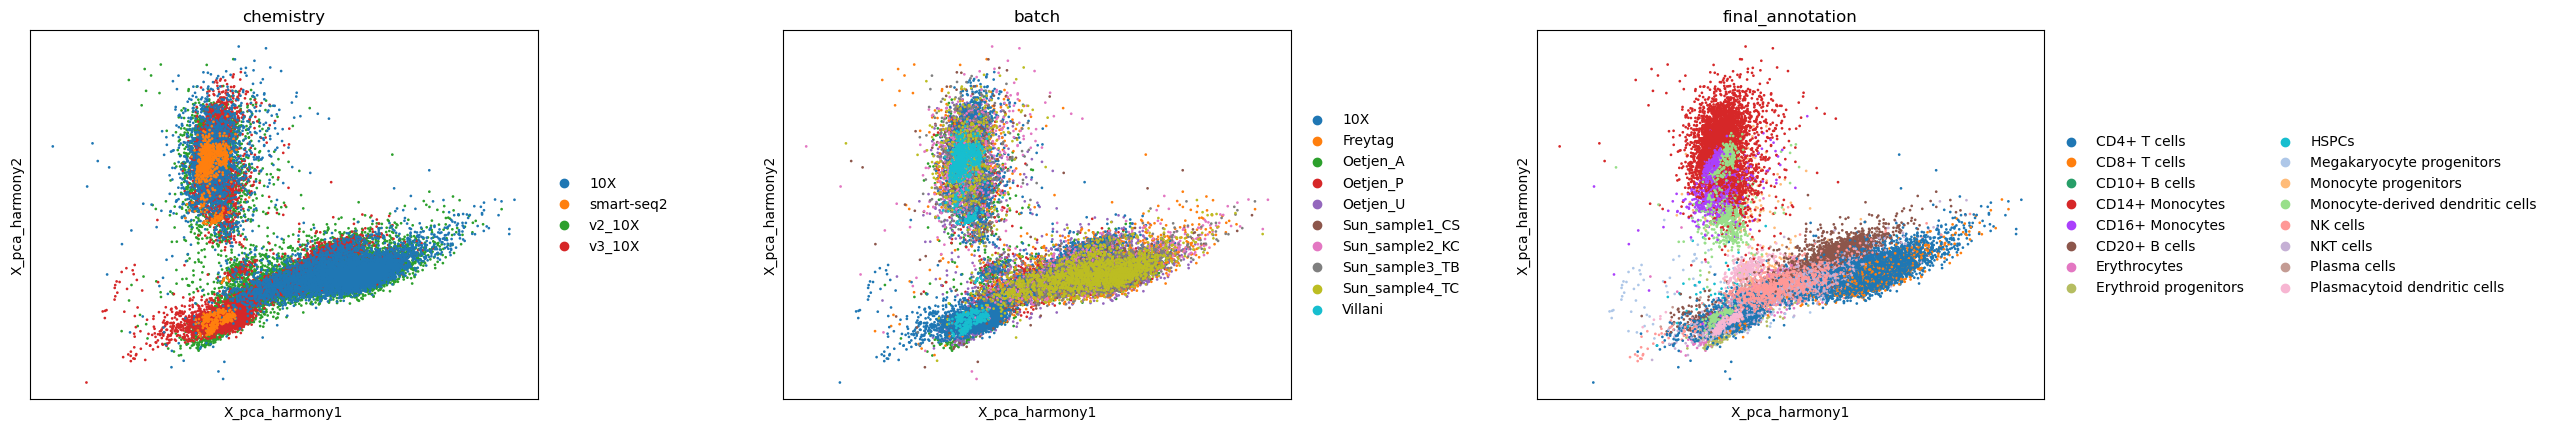

In [27]:
sc.pl.embedding(
    adata,
    "X_pca_harmony",
    color=["chemistry", "batch", "final_annotation"],
    size=15,
    wspace=0.35,
)

## SCVI

In [28]:
# import scvi
# scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
# vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30)
# vae.train()
adata.obsm["scVI"] = adata_scvi.obsm["scVI"]# vae.get_latent_representation()

## Benchmark

In [14]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="final_annotation",
    embedding_obsm_keys=["Unintegrated", "X_vae", "X_pca_harmony", "scVI"],
    n_jobs=6,
)
bm.benchmark()

Metrics:   0%|                                     | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]WARNING:jax._src.lib.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)

Metrics:   0%|                                                                        | 0/10 [00:00<?, ?it/s]
                                                                                                             
Embeddings: 100%|█████████████████████████████████████████████████████████████| 2/2 [10:34<00:00, 317.32s/it]

                                                                                                             

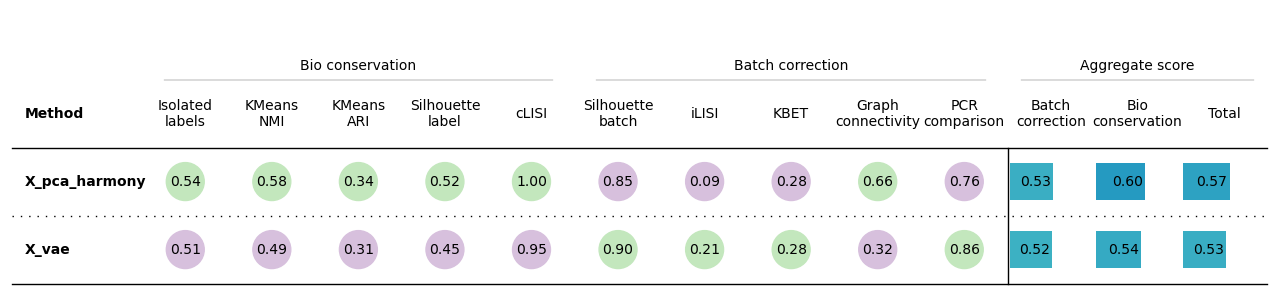

In [15]:
bm.plot_results_table(min_max_scale=False)

In [20]:
df = bm.get_results(min_max_scale=False)

In [21]:
df

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_vae,0.510086,0.463583,0.269847,0.451238,0.944555,0.901079,0.207864,0.285749,0.337868,0.864932,0.519498,0.527862,0.524516
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score
